# Installing Necessary Libraries

In [ ]:
!pip install adapter-transformers==3.2.1
!pip install tree_sitter==0.20.0
!pip install huggingface_hub==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.48.3 requires tokenizers<0.22,>=0.21, but you have tokenizers 0.13.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tree_sitter: filename=tree_sitter-0.20.0-cp311-cp311-linux_x86_64.whl size=390847 sha256=cb4bde0f2cffae8fe0663458b398c1f338e96be292525c038cac0b1bbccdd5c2
  S

# Importing Libraries

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers.adapters.composition import Fuse
from transformers import AutoTokenizer,AutoModel
from model import Seq2Seq
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaModel, RobertaTokenizer)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from parser import (remove_comments_and_docstrings,
                   tree_to_token_index,
                   index_to_code_token,
                   tree_to_variable_index)
import logging
logger = logging.getLogger(__name__)

# Downloading Model

In [ ]:
encoder = RobertaModel.from_pretrained('microsoft/codebert-base',output_attentions = True)
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
config = RobertaConfig.from_pretrained('microsoft/codebert-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

# Injecting Language Adapters to The Model

In [ ]:
for adapter in ("go","java","javascript","php","python","ruby"):
  encoder.load_adapter(f"/content/drive/MyDrive/BERTvisualization/lang_adapters/adapter_{adapter}", load_as=f"adapter_{adapter}", with_head=False)
  encoder.set_active_adapters("adapter_" + adapter)

/usr/local/lib/python3.11/dist-packages/transformers/adapters/loading.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_file, map_locatio

# Loading the entire weights of the finetuned model

In [ ]:
max_source_length = 256
max_target_length = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)

model=Seq2Seq(encoder=encoder,decoder=decoder,config=config,
              beam_size=10,max_length=max_target_length,
              sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)

model.load_state_dict(torch.load("/content/drive/MyDrive/BERTvisualization/python/pytorch_model.bin",map_location=device))

model.to(device)

<ipython-input-50-6df16f00e732>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/BERTvisualization/python/pytorch_m

Seq2Seq(
  (encoder): RobertaModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (key): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (value): Linear(
                in_features=768, out_features=768, 

# Loading Adapter Fusion
Run this block only if you want to perform experiments on Adapter Fusion

In [ ]:
adapter_setup = Fuse("adapter_go","adapter_java","adapter_javascript","adapter_php","adapter_python","adapter_ruby")
encoder.set_active_adapters(adapter_setup)
fusion_name = encoder.load_adapter_fusion("/content/drive/MyDrive/BERTvisualization/fusion",output_attentions = True)


Overwriting existing adapter fusion module 'adapter_go,adapter_java,adapter_javascript,adapter_php,adapter_python,adapter_ruby'
/usr/local/lib/python3.11/dist-packages/transformers/adapters/loading.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 

# Loading AdvFusion
Run this block only if you want to perform experiments on AdvFusion

In [ ]:
adapter_setup = Fuse("adapter_go","adapter_java","adapter_javascript","adapter_php","adapter_python","adapter_ruby")
encoder.set_active_adapters(adapter_setup)
fusion_name = encoder.load_adapter_fusion("/content/drive/MyDrive/BERTvisualization/adv_fusion",output_attentions = True)

Overwriting existing adapter fusion module 'adapter_go,adapter_java,adapter_javascript,adapter_php,adapter_python,adapter_ruby'
/usr/local/lib/python3.11/dist-packages/transformers/adapters/loading.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 

# Parser required for model input

In [ ]:
from parser import DFG_python,DFG_java,DFG_ruby,DFG_go,DFG_php,DFG_javascript
from tree_sitter import Language, Parser

dfg_function={
    'python':DFG_python,
    'java':DFG_java,
    'ruby':DFG_ruby,
    'go':DFG_go,
    'php':DFG_php,
    'javascript':DFG_javascript
}
parsers={}

for lang in dfg_function:
    LANGUAGE = Language('parser/my-languages.so', lang)
    parser = Parser()
    parser.set_language(LANGUAGE)
    parser = [parser,dfg_function[lang]]
    parsers[lang]= parser

# Necessary funstions to convert data to appropriate input for the model

In [ ]:
#remove comments, tokenize code and extract dataflow
from tqdm import tqdm, trange


def extract_dataflow(code, parser,lang):
    #remove comments
    try:
        code=remove_comments_and_docstrings(code,lang)
    except:
        pass
    #obtain dataflow
    if lang=="php":
        code="<?php"+code+"?>"
    try:
        tree = parser[0].parse(bytes(code,'utf8'))
        root_node = tree.root_node
        tokens_index=tree_to_token_index(root_node)
        code=code.split('\n')
        code_tokens=[index_to_code_token(x,code) for x in tokens_index]
        index_to_code={}
        for idx,(index,code) in enumerate(zip(tokens_index,code_tokens)):
            index_to_code[index]=(idx,code)
        try:
            DFG,_=parser[1](root_node,index_to_code,{})
        except:
            DFG=[]
        DFG=sorted(DFG,key=lambda x:x[1])
        indexs=set()
        for d in DFG:
            if len(d[-1])!=0:
                indexs.add(d[1])
            for x in d[-1]:
                indexs.add(x)
        new_DFG=[]
        for d in DFG:
            if d[1] in indexs:
                new_DFG.append(d)
        dfg=new_DFG
    except:
        dfg=[]
    return code_tokens,dfg


class Example(object):
    """A single training/test example."""
    def __init__(self,
                 idx,
                 source,
                 target,
                 ):
        self.idx = idx
        self.source = source
        self.target = target

def read_examples(filename):
    """Read examples from filename."""
    examples=[]
    with open(filename,encoding="utf-8") as f:
        for idx, line in enumerate(f):
            line=line.strip()
            js=json.loads(line)
            if 'idx' not in js:
                js['idx']=idx
            code=' '.join(js['code_tokens']).replace('\n',' ')
            code=' '.join(code.strip().split())
            nl=' '.join(js['docstring_tokens']).replace('\n','')
            nl=' '.join(nl.strip().split())
            examples.append(
                Example(
                        idx = idx,
                        source=code,
                        target = nl,
                        )
            )
    return examples


class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 example_id,
                 source_ids,
                 position_idx,
                 dfg_to_code,
                 dfg_to_dfg,
                 target_ids,
                 source_mask,
                 target_mask,

    ):
        self.example_id = example_id
        self.source_ids = source_ids
        self.position_idx = position_idx
        self.dfg_to_code = dfg_to_code
        self.dfg_to_dfg = dfg_to_dfg
        self.target_ids = target_ids
        self.source_mask = source_mask
        self.target_mask = target_mask

lang = "java"
def convert_examples_to_features(examples, tokenizer,stage=None):
    features = []
    for example_index, example in enumerate(tqdm(examples,total=len(examples))):
        ##extract data flow
        code_tokens,dfg=extract_dataflow(example.source,parsers[lang],lang)
        code_tokens=[tokenizer.tokenize('@ '+x)[1:] if idx!=0 else tokenizer.tokenize(x) for idx,x in enumerate(code_tokens)]
        ori2cur_pos={}
        ori2cur_pos[-1]=(0,0)
        for i in range(len(code_tokens)):
            ori2cur_pos[i]=(ori2cur_pos[i-1][1],ori2cur_pos[i-1][1]+len(code_tokens[i]))
        code_tokens=[y for x in code_tokens for y in x]

        #truncating
        code_tokens=code_tokens[:max_source_length-3]
        source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
        source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
        position_idx = [i+tokenizer.pad_token_id + 1 for i in range(len(source_tokens))]
        dfg=dfg[:max_source_length-len(source_tokens)]
        source_tokens+=[x[0] for x in dfg]
        position_idx+=[0 for x in dfg]
        source_ids+=[tokenizer.unk_token_id for x in dfg]
        padding_length=max_source_length-len(source_ids)
        position_idx+=[tokenizer.pad_token_id]*padding_length
        source_ids+=[tokenizer.pad_token_id]*padding_length
        source_mask = [1] * (len(source_tokens))
        source_mask+=[0]*padding_length

        #reindex
        reverse_index={}
        for idx,x in enumerate(dfg):
            reverse_index[x[1]]=idx
        for idx,x in enumerate(dfg):
            dfg[idx]=x[:-1]+([reverse_index[i] for i in x[-1] if i in reverse_index],)
        dfg_to_dfg=[x[-1] for x in dfg]
        dfg_to_code=[ori2cur_pos[x[1]] for x in dfg]
        length=len([tokenizer.cls_token])
        dfg_to_code=[(x[0]+length,x[1]+length) for x in dfg_to_code]

        #target
        if stage=="test":
            target_tokens = tokenizer.tokenize("None")
        else:
            target_tokens = tokenizer.tokenize(example.target)[:max_target_length-2]
        target_tokens = [tokenizer.cls_token]+target_tokens+[tokenizer.sep_token]
        target_ids = tokenizer.convert_tokens_to_ids(target_tokens)
        target_mask = [1] *len(target_ids)
        padding_length = max_target_length - len(target_ids)
        target_ids+=[tokenizer.pad_token_id]*padding_length
        target_mask+=[0]*padding_length

        if example_index < 5:
            if stage=='train':
                logger.info("*** Example ***")
                logger.info("source_tokens: {}".format([x.replace('\u0120','_') for x in source_tokens]))
                logger.info("source_ids: {}".format(' '.join(map(str, source_ids))))
                logger.info("source_mask: {}".format(' '.join(map(str, source_mask))))
                logger.info("position_idx: {}".format(position_idx))
                logger.info("dfg_to_code: {}".format(' '.join(map(str, dfg_to_code))))
                logger.info("dfg_to_dfg: {}".format(' '.join(map(str, dfg_to_dfg))))

                logger.info("target_tokens: {}".format([x.replace('\u0120','_') for x in target_tokens]))
                logger.info("target_ids: {}".format(' '.join(map(str, target_ids))))
                logger.info("target_mask: {}".format(' '.join(map(str, target_mask))))

        features.append(
            InputFeatures(
                 example_index,
                 source_ids,
                 position_idx,
                 dfg_to_code,
                 dfg_to_dfg,
                 target_ids,
                 source_mask,
                 target_mask,
            )
        )
    return features

In [ ]:
max_source_length = 256
max_target_length = 128

class TextDataset(Dataset):
    def __init__(self, examples,file_path=None):
        self.examples = examples


    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        #calculate graph-guided masked function
        attn_mask=np.zeros((max_source_length,max_source_length),dtype=bool)
        #calculate begin index of node and max length of input
        node_index=sum([i>1 for i in self.examples[item].position_idx])
        max_length=sum([i!=1 for i in self.examples[item].position_idx])
        #sequence can attend to sequence
        attn_mask[:node_index,:node_index]=True
        #special tokens attend to all tokens
        for idx,i in enumerate(self.examples[item].source_ids):
            if i in [0,2]:
                attn_mask[idx,:max_length]=True
        #nodes attend to code tokens that are identified from
        for idx,(a,b) in enumerate(self.examples[item].dfg_to_code):
            if a<node_index and b<node_index:
                attn_mask[idx+node_index,a:b]=True
                attn_mask[a:b,idx+node_index]=True
        #nodes attend to adjacent nodes
        for idx,nodes in enumerate(self.examples[item].dfg_to_dfg):
            for a in nodes:
                if a+node_index<len(self.examples[item].position_idx):
                    attn_mask[idx+node_index,a+node_index]=True

        return (torch.tensor(self.examples[item].source_ids),
                torch.tensor(self.examples[item].source_mask),
                torch.tensor(self.examples[item].position_idx),
                torch.tensor(attn_mask),
                torch.tensor(self.examples[item].target_ids),
                torch.tensor(self.examples[item].target_mask),)


# Load the test dataset you would like to do experiments on

In [ ]:
import json
train_examples = read_examples("/content/drive/MyDrive/CodeBert/CodeBERT/CodeBERT/code2nl/data/code2nl/CodeSearchNet/php/test.jsonl")
train_features = convert_examples_to_features(train_examples, tokenizer,stage='test')
train_data = TextDataset(train_features)


100%|██████████| 2000/2000 [00:15<00:00, 131.51it/s]


# Embedding Extraction

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_sampler = SequentialSampler(train_data)
eval_dataloader = DataLoader(train_data, sampler=eval_sampler, batch_size=16,num_workers=0)
concatenated_array = np.empty((12, 0, 256, 6))
p=[]
encoder.to(device)
for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
    batch = tuple(t.to(device) for t in batch)
    source_ids,source_mask,position_idx,att_mask,target_ids,target_mask = batch
    with torch.no_grad():
        outputs = model.encoder(source_ids, attention_mask=source_mask,output_adapter_fusion_attentions=True)
        temp = np.empty((0, 16 , 256, 6))
        for i in range(12):
          try:
            temp = np.concatenate((temp, [outputs.adapter_fusion_attentions[fusion_name][i]['output_adapter']]),axis=0)
          except:
            pass
        try:
          concatenated_array = np.concatenate((concatenated_array, temp), axis=1)
        except:
          pass

accumulated_array = np.sum(concatenated_array, axis=(1, 2))
normed_matrix = normalize(accumulated_array, axis=1, norm='l1')

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


# Save or load previous embeddings

In [ ]:
np.save('adv_python_embeddings.npy', normed_matrix)
# normed_matrix = np.load('go_embeddings.npy')

# Visualization Function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# adapter_setup = Fuse("python_adapter", "php_adapter" ,"go_adapter","ruby_adapter","java_adapter","javascript_adapter")

import matplotlib.pyplot as plt
import numpy as np
# adapter_setup = Fuse("python_adapter", "php_adapter" ,"go_adapter","ruby_adapter","java_adapter","javascript_adapter")

def stacked_visualize_layers(normed_matrix):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(12,6))
    labels = ['L1', 'L2', 'L3', 'L4', 'L5','L6','L7','L8','L9','L10','L11','L12']


    python = normed_matrix[:,4]
    php = normed_matrix[:,3]
    go = normed_matrix[:,0]
    ruby = normed_matrix[:,5]
    java = normed_matrix[:,1]
    javascript = normed_matrix[:,2]

    normed_matrix = np.round(normed_matrix* 100, 1)
    python_label = [str(v)+"%" if v >= 2 else "" for v in normed_matrix[:,4]]
    php_label = [str(v)+"%" if v >= 2 else "" for v in normed_matrix[:,3]]
    go_label = [str(v)+"%" if v >= 2 else "" for v in normed_matrix[:,0]]
    ruby_label = [str(v)+"%" if v >= 2 else "" for v in normed_matrix[:,5]]
    java_label = [str(v)+"%" if v >= 2 else "" for v in normed_matrix[:,1]]
    javascript_label = [str(v)+"%" if v >= 2 else "" for v in normed_matrix[:,2]]


    b1 = ax.barh(labels, go)
    b2 = ax.barh(labels, java,left=go)
    b3 = ax.barh(labels, javascript,left=go+java)
    b4 = ax.barh(labels, php,left=go+java+javascript)
    b5 = ax.barh(labels, python,left=go+java+javascript+php)
    b6 = ax.barh(labels, ruby,left=go+java+javascript+php+python)

    ax.bar_label(b1,labels = go_label, label_type='center')
    ax.bar_label(b2,labels = java_label, label_type='center')
    ax.bar_label(b3,labels = javascript_label, label_type='center')
    ax.bar_label(b4,labels = php_label, label_type='center')
    ax.bar_label(b5,labels = python_label, label_type='center')
    ax.bar_label(b6,labels = ruby_label, label_type='center')

    # ax.legend([b1, b2,b3,b4,b5,b6], ["python", "php","go","ruby","java","javascript"], title="Normalized attention", loc="upper right")
    ax.legend(["go", "java","javascript","php","python","ruby"],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=6)

    plt.show()

# Javascript Fusion Adapter  

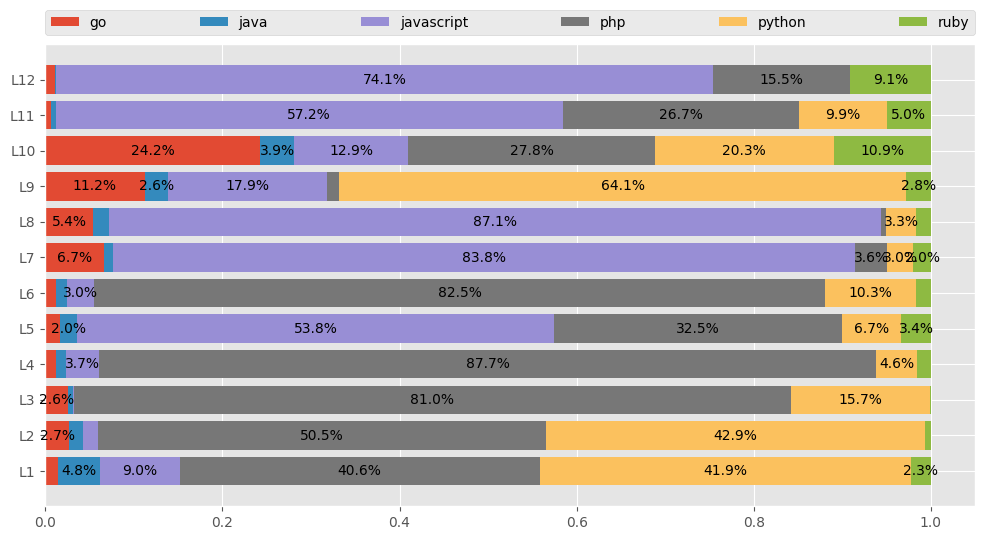

In [ ]:
stacked_visualize_layers(normed_matrix)

# Javascript AdvFusion

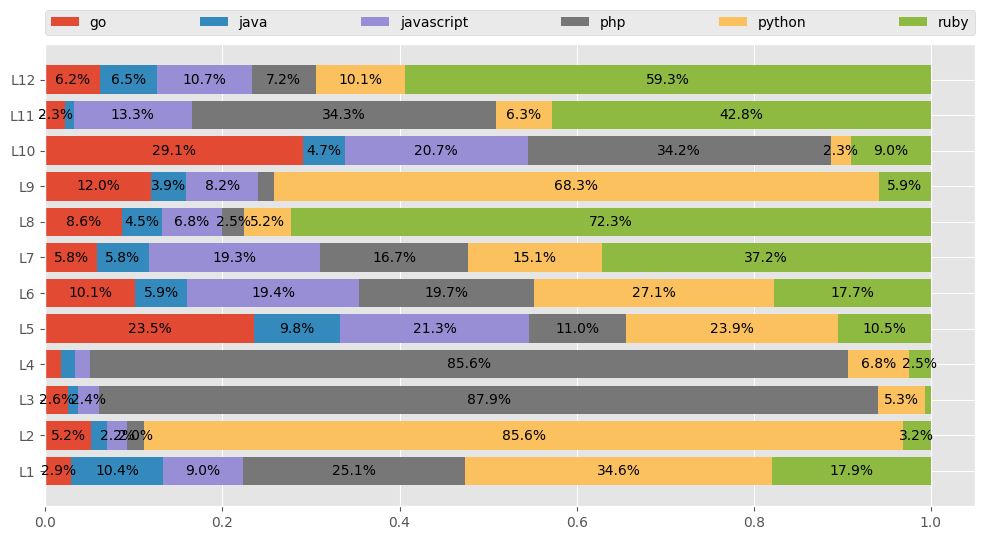

In [ ]:

stacked_visualize_layers(normed_matrix)

# Go Fusion Adapter

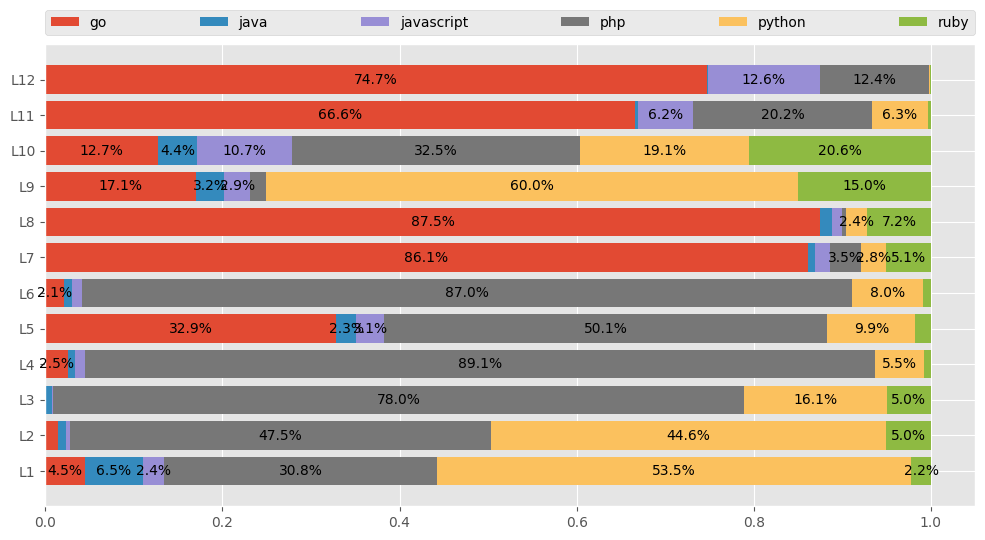

In [ ]:
stacked_visualize_layers(normed_matrix)

# Go AdvFusion Adapter

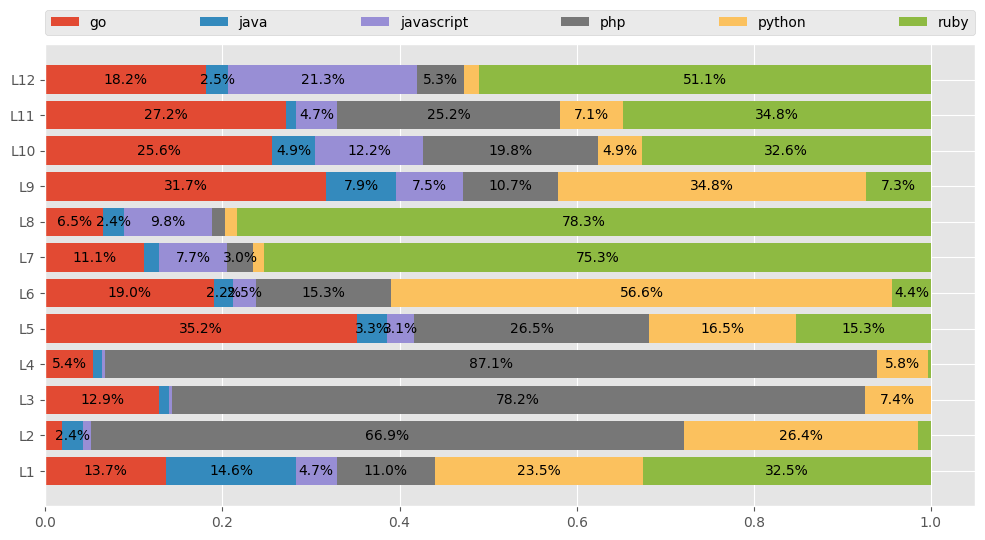

In [ ]:
stacked_visualize_layers(normed_matrix)

# Java Fusion

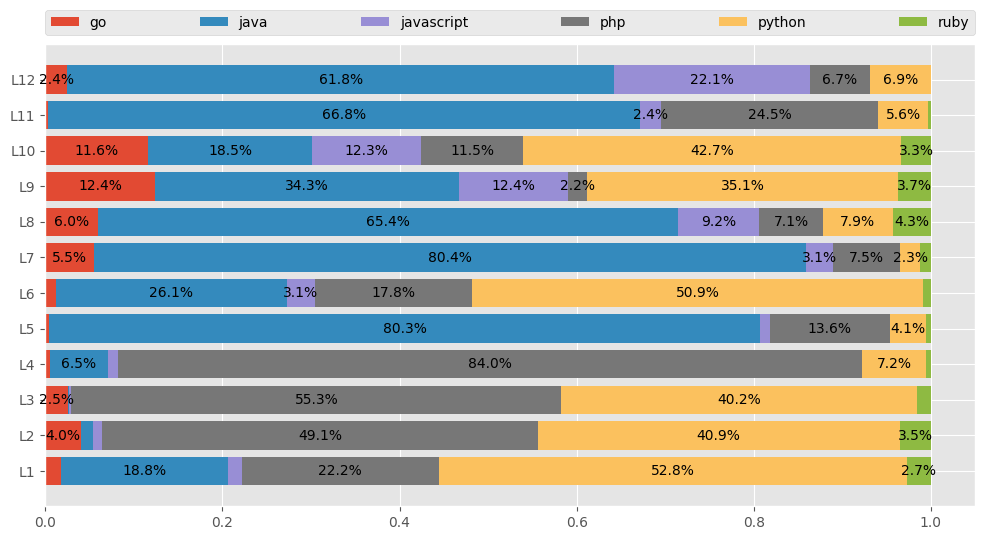

In [ ]:
stacked_visualize_layers(normed_matrix)

# Java adv fusion

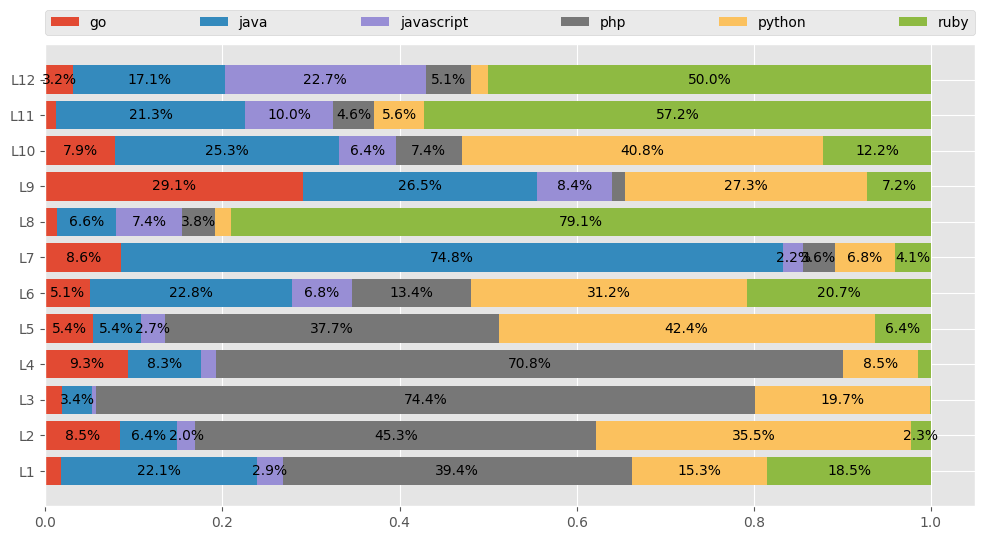

In [ ]:
stacked_visualize_layers(normed_matrix)

# Python Fusion

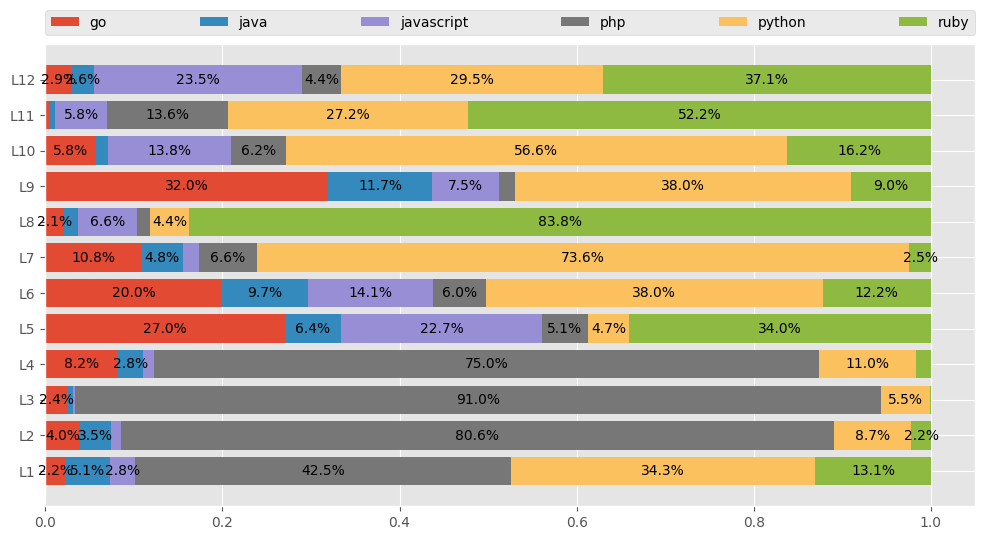

In [ ]:
stacked_visualize_layers(normed_matrix)

#Python AdvFusion


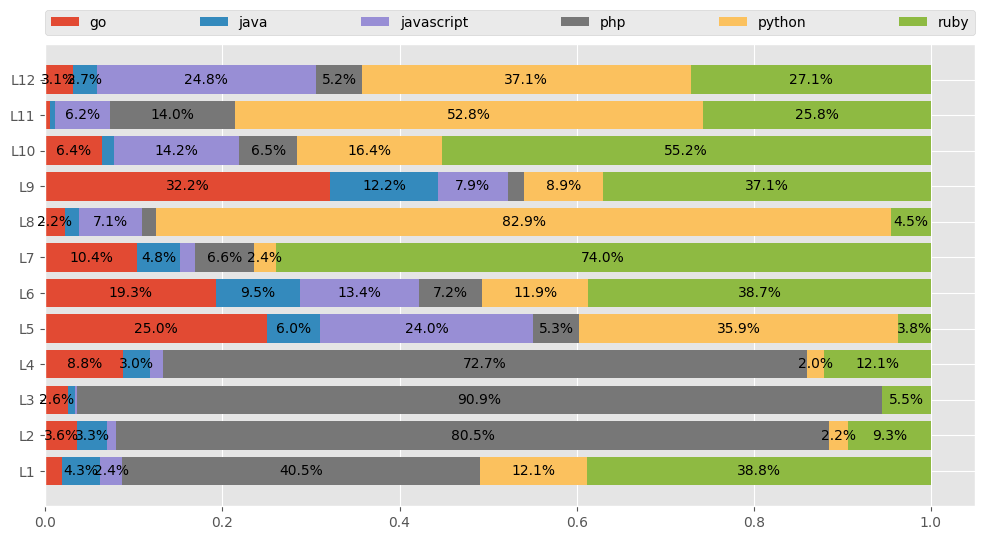

In [ ]:
stacked_visualize_layers(normed_matrix)

# PHP Fusion

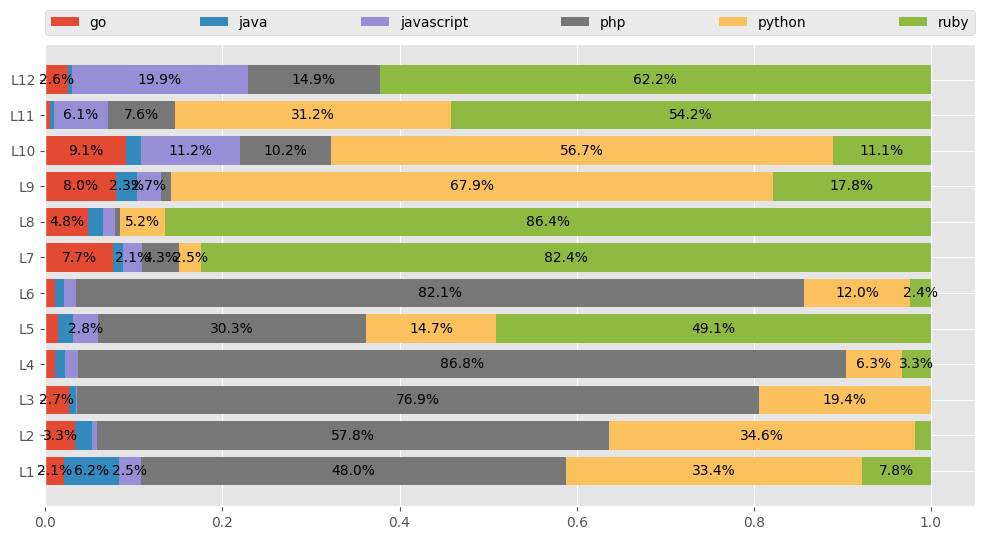

In [ ]:
stacked_visualize_layers(normed_matrix)

# PHP AdvFusion

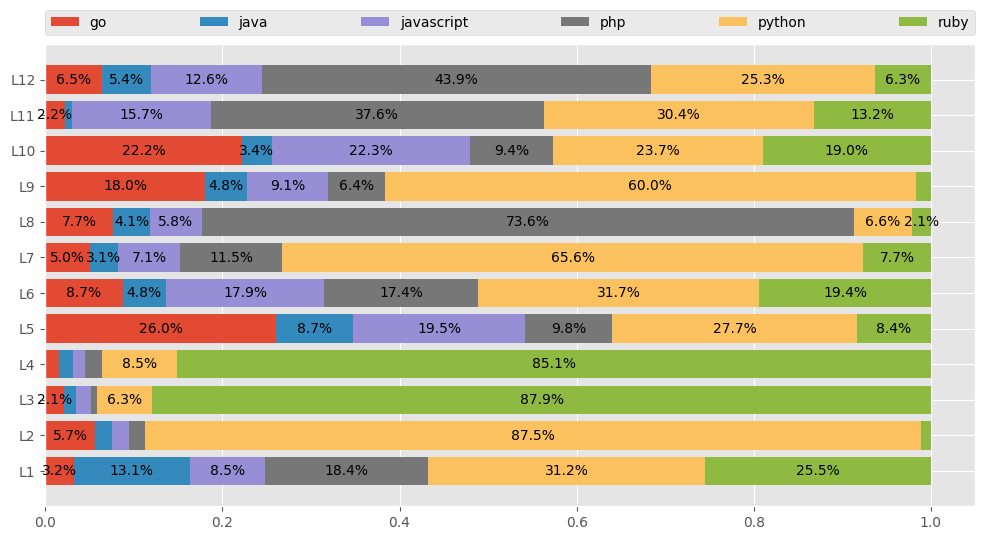

In [ ]:
stacked_visualize_layers(normed_matrix)